In [53]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [54]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
df = pd.read_csv('/content/drive/MyDrive/HW google/GOOG.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-18,53.092999,53.497002,53.034000,53.318001,53.318001,31304000
1,2018-05-21,53.702999,54.400002,53.682499,53.979000,53.979000,20464000
2,2018-05-22,54.178001,54.329498,53.334499,53.486500,53.486500,21800000
3,2018-05-23,53.256500,54.039001,53.085499,53.984501,53.984501,21214000
4,2018-05-24,53.950001,54.023499,53.307499,53.962002,53.962002,15336000
...,...,...,...,...,...,...,...
1255,2023-05-15,116.489998,118.794998,116.480003,116.959999,116.959999,22107900
1256,2023-05-16,116.830002,121.199997,116.830002,120.089996,120.089996,32370100
1257,2023-05-17,120.180000,122.279999,119.459999,121.480003,121.480003,26659600
1258,2023-05-18,121.559998,123.900002,121.489998,123.519997,123.519997,27014500


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [57]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [58]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1260 non-null   float64       
 2   High       1260 non-null   float64       
 3   Low        1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Adj Close  1260 non-null   float64       
 6   Volume     1260 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


In [59]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,2018-05-18,53.318001
1,2018-05-21,53.979000
2,2018-05-22,53.486500
3,2018-05-23,53.984501
4,2018-05-24,53.962002


In [60]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe() 

,Close
count,1260.000000
mean,89.516771
std,30.150199
min,48.811001
25%,60.555250
50%,86.767250
75%,114.176250
max,150.709000


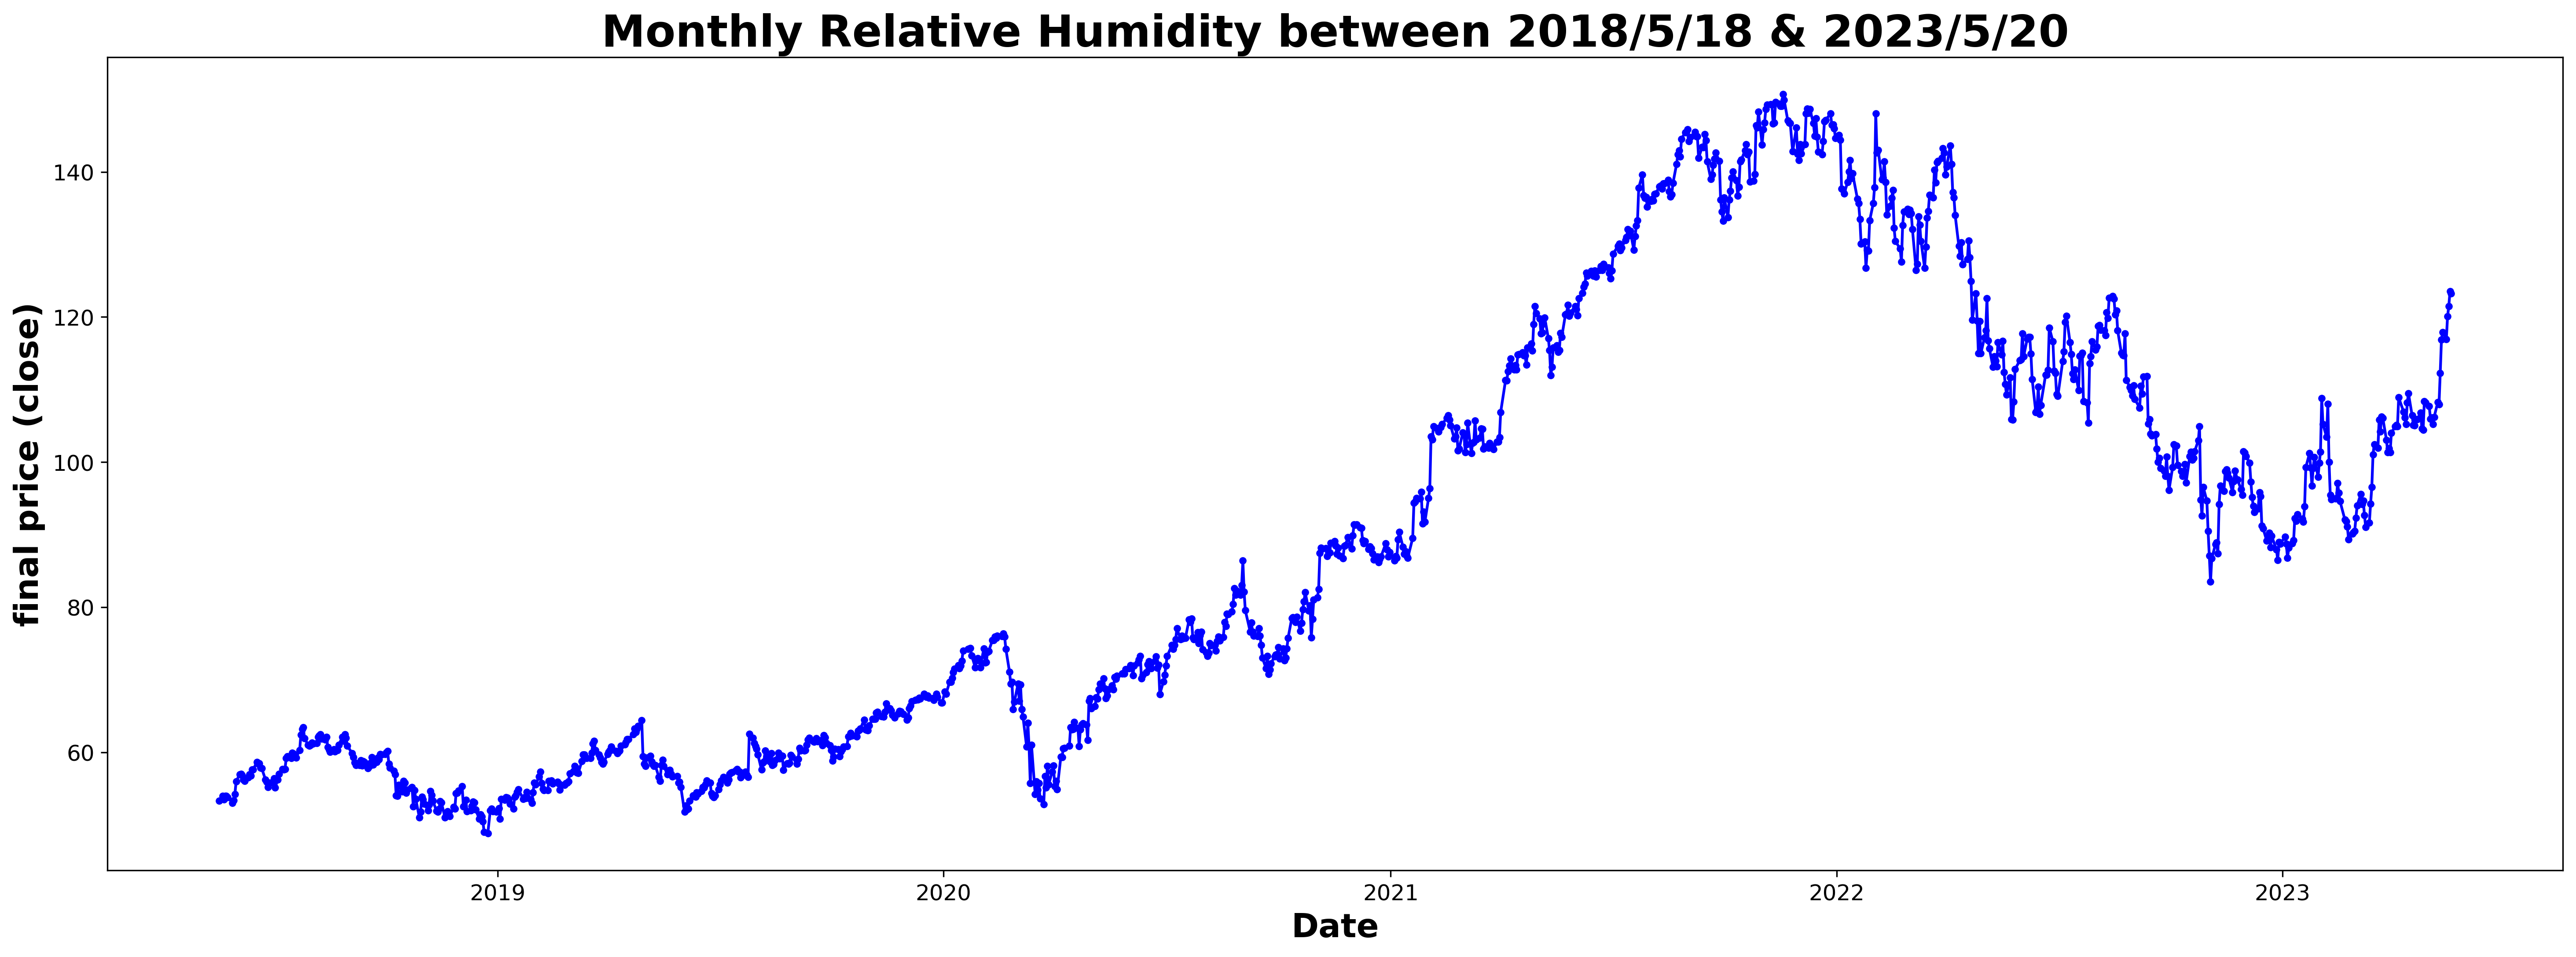

In [61]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('daily stock market of GOOG between 2018/5/18 & 2023/5/20',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('final price (close)',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [62]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018-05-18,53.318001,NaN,NaN,NaN
1,2018-05-21,53.979000,53.318001,NaN,NaN
2,2018-05-22,53.486500,53.979000,53.318001,NaN
3,2018-05-23,53.984501,53.486500,53.979000,53.318001
4,2018-05-24,53.962002,53.984501,53.486500,53.979000


In [63]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018-05-23,53.984501,53.486500,53.979000,53.318001
1,2018-05-24,53.962002,53.984501,53.486500,53.979000
2,2018-05-25,53.783001,53.962002,53.984501,53.486500
3,2018-05-29,53.015999,53.783001,53.962002,53.984501
4,2018-05-30,53.389999,53.015999,53.783001,53.962002
...,...,...,...,...,...
1252,2023-05-15,116.959999,117.919998,116.900002,112.279999
1253,2023-05-16,120.089996,116.959999,117.919998,116.900002
1254,2023-05-17,121.480003,120.089996,116.959999,117.919998
1255,2023-05-18,123.519997,121.480003,120.089996,116.959999


In [ ]:
# Export the data
#clean_df.to_csv('D:/data_analysis/PyExport/Rainfall_Lags.csv',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 5 years are in the data set. In this practice, we will use the last 1 year of data as the testing set

In [68]:
# Train data
Forecast_train_data=clean_df.iloc[0:1077,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018-05-23,53.984501,53.486500,53.979000,53.318001
1,2018-05-24,53.962002,53.984501,53.486500,53.979000
2,2018-05-25,53.783001,53.962002,53.984501,53.486500
3,2018-05-29,53.015999,53.783001,53.962002,53.984501
4,2018-05-30,53.389999,53.015999,53.783001,53.962002
...,...,...,...,...,...
1072,2022-08-25,117.699997,114.699997,114.769997,115.070000
1073,2022-08-26,111.300003,117.699997,114.699997,114.769997
1074,2022-08-29,110.339996,111.300003,117.699997,114.699997
1075,2022-08-30,109.910004,110.339996,111.300003,117.699997


In [69]:
# Test data
Forecast_test_data=clean_df.iloc[1077:1077+180,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
1077,2022-09-01,110.550003,109.150002,109.910004,110.339996
1078,2022-09-02,108.680000,110.550003,109.150002,109.910004
1079,2022-09-06,107.480003,108.680000,110.550003,109.150002
1080,2022-09-07,110.480003,107.480003,108.680000,110.550003
1081,2022-09-08,109.419998,110.480003,107.480003,108.680000
...,...,...,...,...,...
1252,2023-05-15,116.959999,117.919998,116.900002,112.279999
1253,2023-05-16,120.089996,116.959999,117.919998,116.900002
1254,2023-05-17,121.480003,120.089996,116.959999,117.919998
1255,2023-05-18,123.519997,121.480003,120.089996,116.959999


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Rolling window

In [72]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:537,:].copy()
Rol_val_1=Forecast_train_data.iloc[537:537+180,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[177:717,:].copy()
Rol_val_2=Forecast_train_data.iloc[717:717+180,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[357:897,:].copy()
Rol_val_3=Forecast_train_data.iloc[897:897+180,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [75]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()

# 6. Creating Net 

In [76]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.169873,0.187767,0.163751
1,0.187967,0.169873,0.187767
2,0.187149,0.187967,0.169873
3,0.180646,0.187149,0.187967
4,0.152778,0.180646,0.187149


In [77]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [78]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [79]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net

opt=Adam(learning_rate=0.01,beta_1=0.5)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [80]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
17/17 [==============================] - 1s 11ms/step - loss: 57.5889 - mean_absolute_percentage_error: 94.9324 - val_loss: 70.7090 - val_mean_absolute_percentage_error: 82.0771
Epoch 2/300
17/17 [==============================] - 0s 3ms/step - loss: 16.2507 - mean_absolute_percentage_error: 26.9707 - val_loss: 24.2726 - val_mean_absolute_percentage_error: 29.1164
Epoch 3/300
17/17 [==============================] - 0s 3ms/step - loss: 3.2273 - mean_absolute_percentage_error: 5.2739 - val_loss: 26.8593 - val_mean_absolute_percentage_error: 31.2065
Epoch 4/300
17/17 [==============================] - 0s 3ms/step - loss: 1.6440 - mean_absolute_percentage_error: 2.7131 - val_loss: 25.1985 - val_mean_absolute_percentage_error: 29.1672
Epoch 5/300
17/17 [==============================] - 0s 3ms/step - loss: 1.3826 - mean_absolute_percentage_error: 2.2825 - val_loss: 26.2448 - val_mean_absolute_percentage_error: 30.3587
Epoch 6/300
17/17 [==============================] - 0s 2ms/

In [81]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

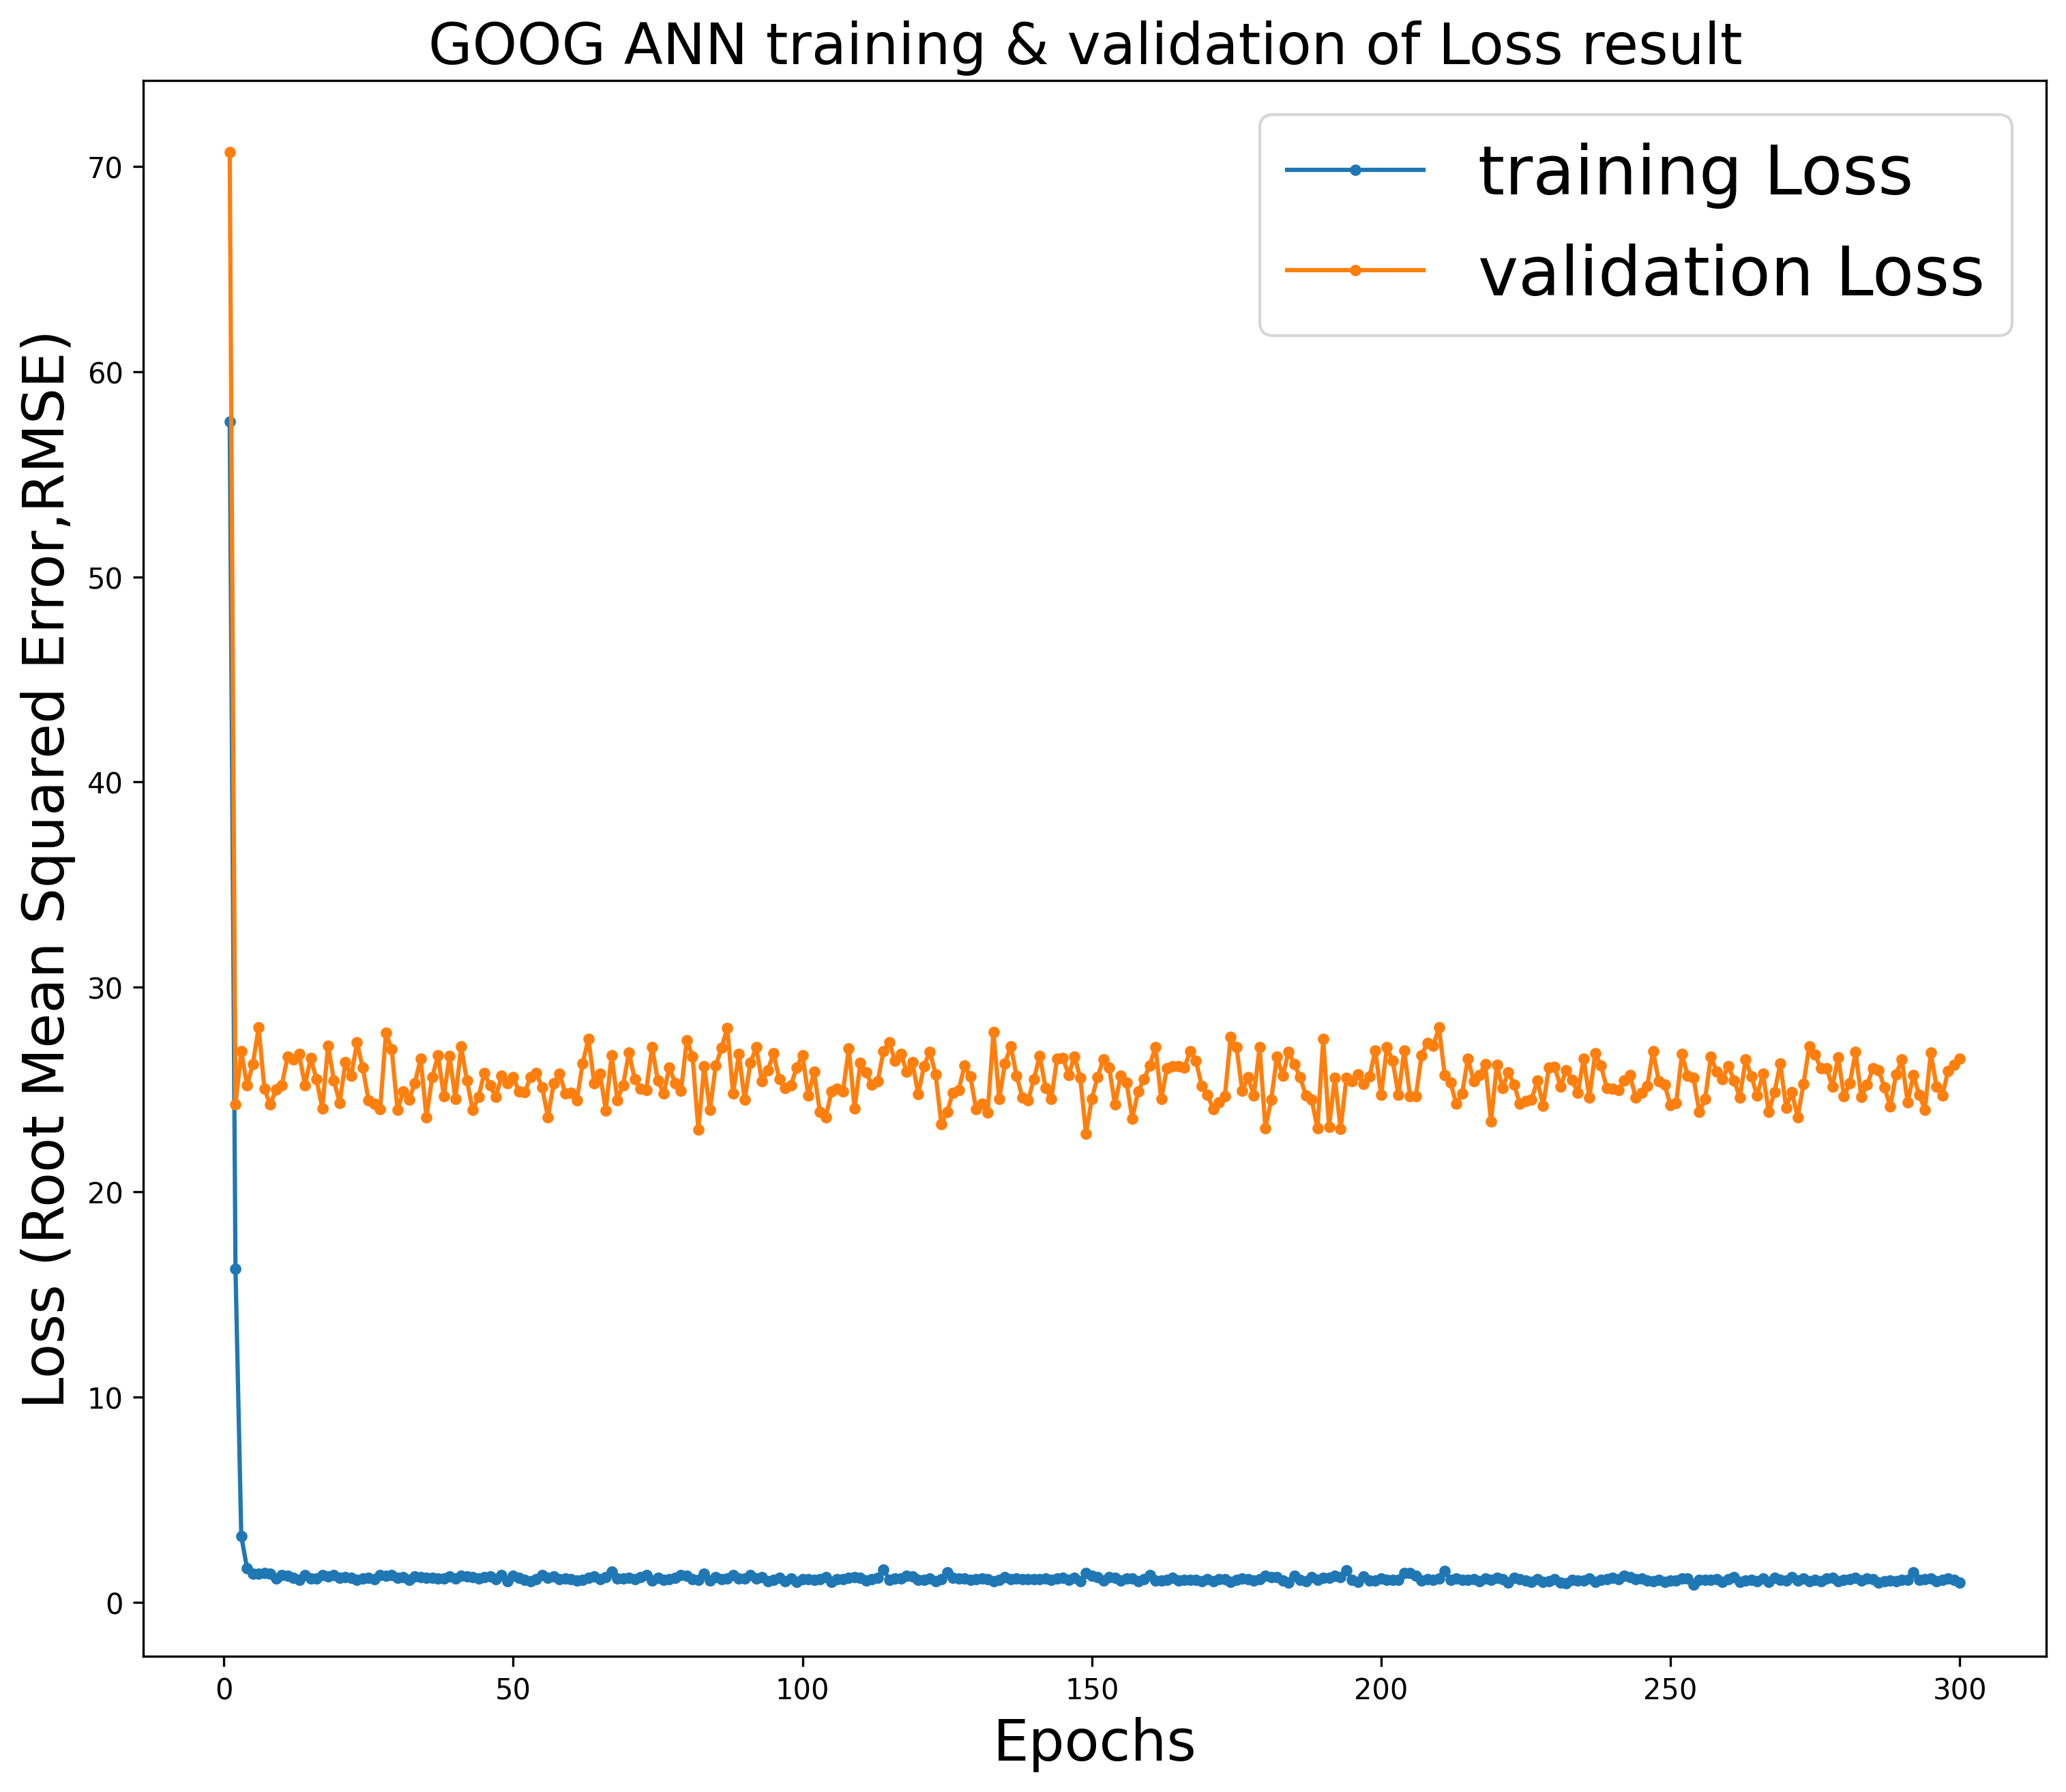

In [83]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('GOOG ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

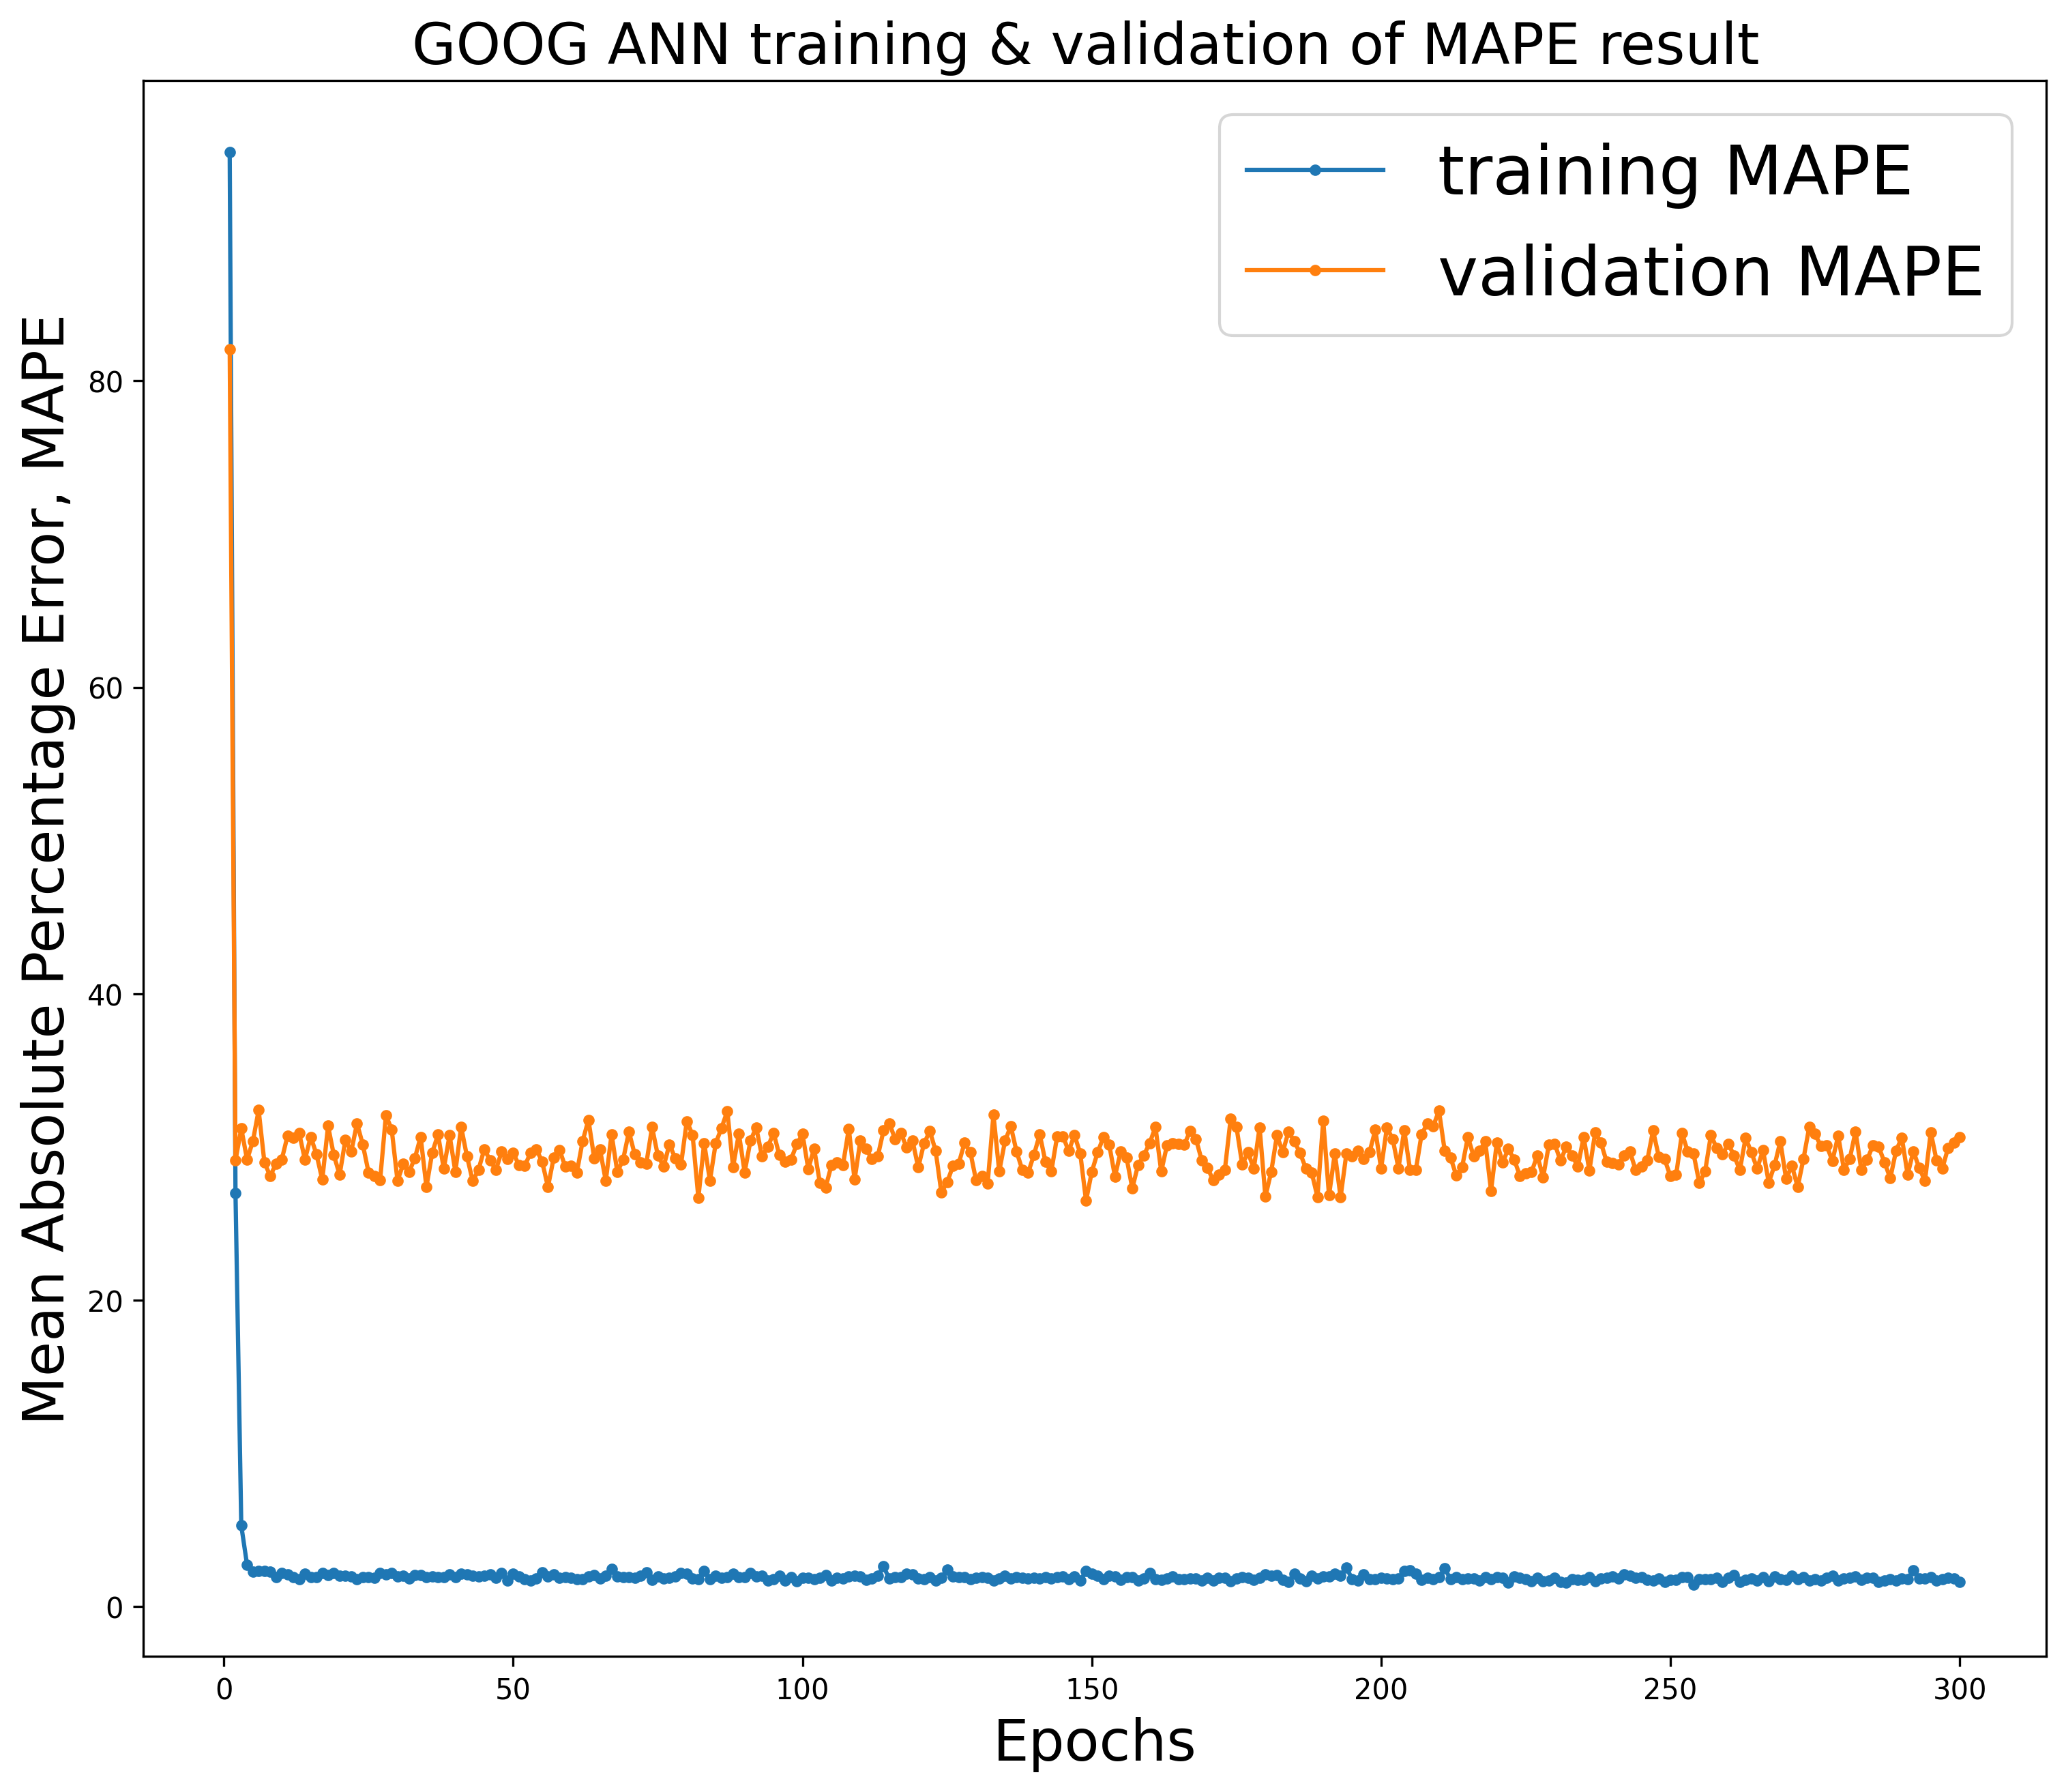

In [84]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('GOOG ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

In [90]:
# 7.3 Save the trained model
model.save('/content/drive/MyDrive/HW google/GOOG_ANN_trained_model com3-1.h5')
# Colab

print('Model has been saved...')

Model has been saved...


In [91]:
# 7.4 Restore the saved model for testing
ANN_model=keras.models.load_model('/content/drive/MyDrive/HW google/GOOG_ANN_trained_model com3-1.h5')
# Colab

print('Model successfully loaded...')

Model successfully loaded...


# Fit the final model with all of the training data

In [87]:
#用找到最好超參數，在建model
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [ ]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.002,beta_1=0.95)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#最後final model # Store in the history for more useful information #用整段train
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
4/4 [==============================] - 0s 4ms/step - loss: 4.6716 - mean_absolute_percentage_error: 7.5387
Epoch 2/300
4/4 [==============================] - 0s 5ms/step - loss: 4.5953 - mean_absolute_percentage_error: 7.5145
Epoch 3/300
4/4 [==============================] - 0s 7ms/step - loss: 4.6289 - mean_absolute_percentage_error: 7.6003
Epoch 4/300
4/4 [==============================] - 0s 5ms/step - loss: 4.5223 - mean_absolute_percentage_error: 7.3393
Epoch 5/300
4/4 [==============================] - 0s 4ms/step - loss: 4.6418 - mean_absolute_percentage_error: 7.4922
Epoch 6/300
4/4 [==============================] - 0s 4ms/step - loss: 4.6984 - mean_absolute_percentage_error: 7.7531
Epoch 7/300
4/4 [==============================] - 0s 4ms/step - loss: 4.5350 - mean_absolute_percentage_error: 7.3915
Epoch 8/300
4/4 [==============================] - 0s 6ms/step - loss: 4.8632 - mean_absolute_percentage_error: 7.7856
Epoch 9/300
4/4 [==============================]

# 8. Testing

In [ ]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [ ]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Y'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
213,2018-01-01,54.31,60.080002,5.770002
214,2018-02-01,44.69,51.570000,6.880000
215,2018-03-01,42.81,44.459999,1.649999
216,2018-04-01,51.31,43.709999,7.600001
217,2018-05-01,59.19,64.400002,5.210002
218,2018-06-01,81.81,71.260002,10.549998
219,2018-07-01,91.00,89.150002,1.849998
220,2018-08-01,89.94,93.970001,4.030001
221,2018-09-01,85.44,87.699997,2.259997
222,2018-10-01,69.38,75.070000,5.690000


In [ ]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 4.621
MSE: 33.928
RMSE: 5.825
MAPE: 7.59 %
SMAPE: 7.429 %
RAE: 0.283
MRAE: 0.00785323513767425
MdRAE: 0.29 bench: 68.07
RSE: 0.104
RRSE: 0.322


#  Plot for comparing true value & predicted value 

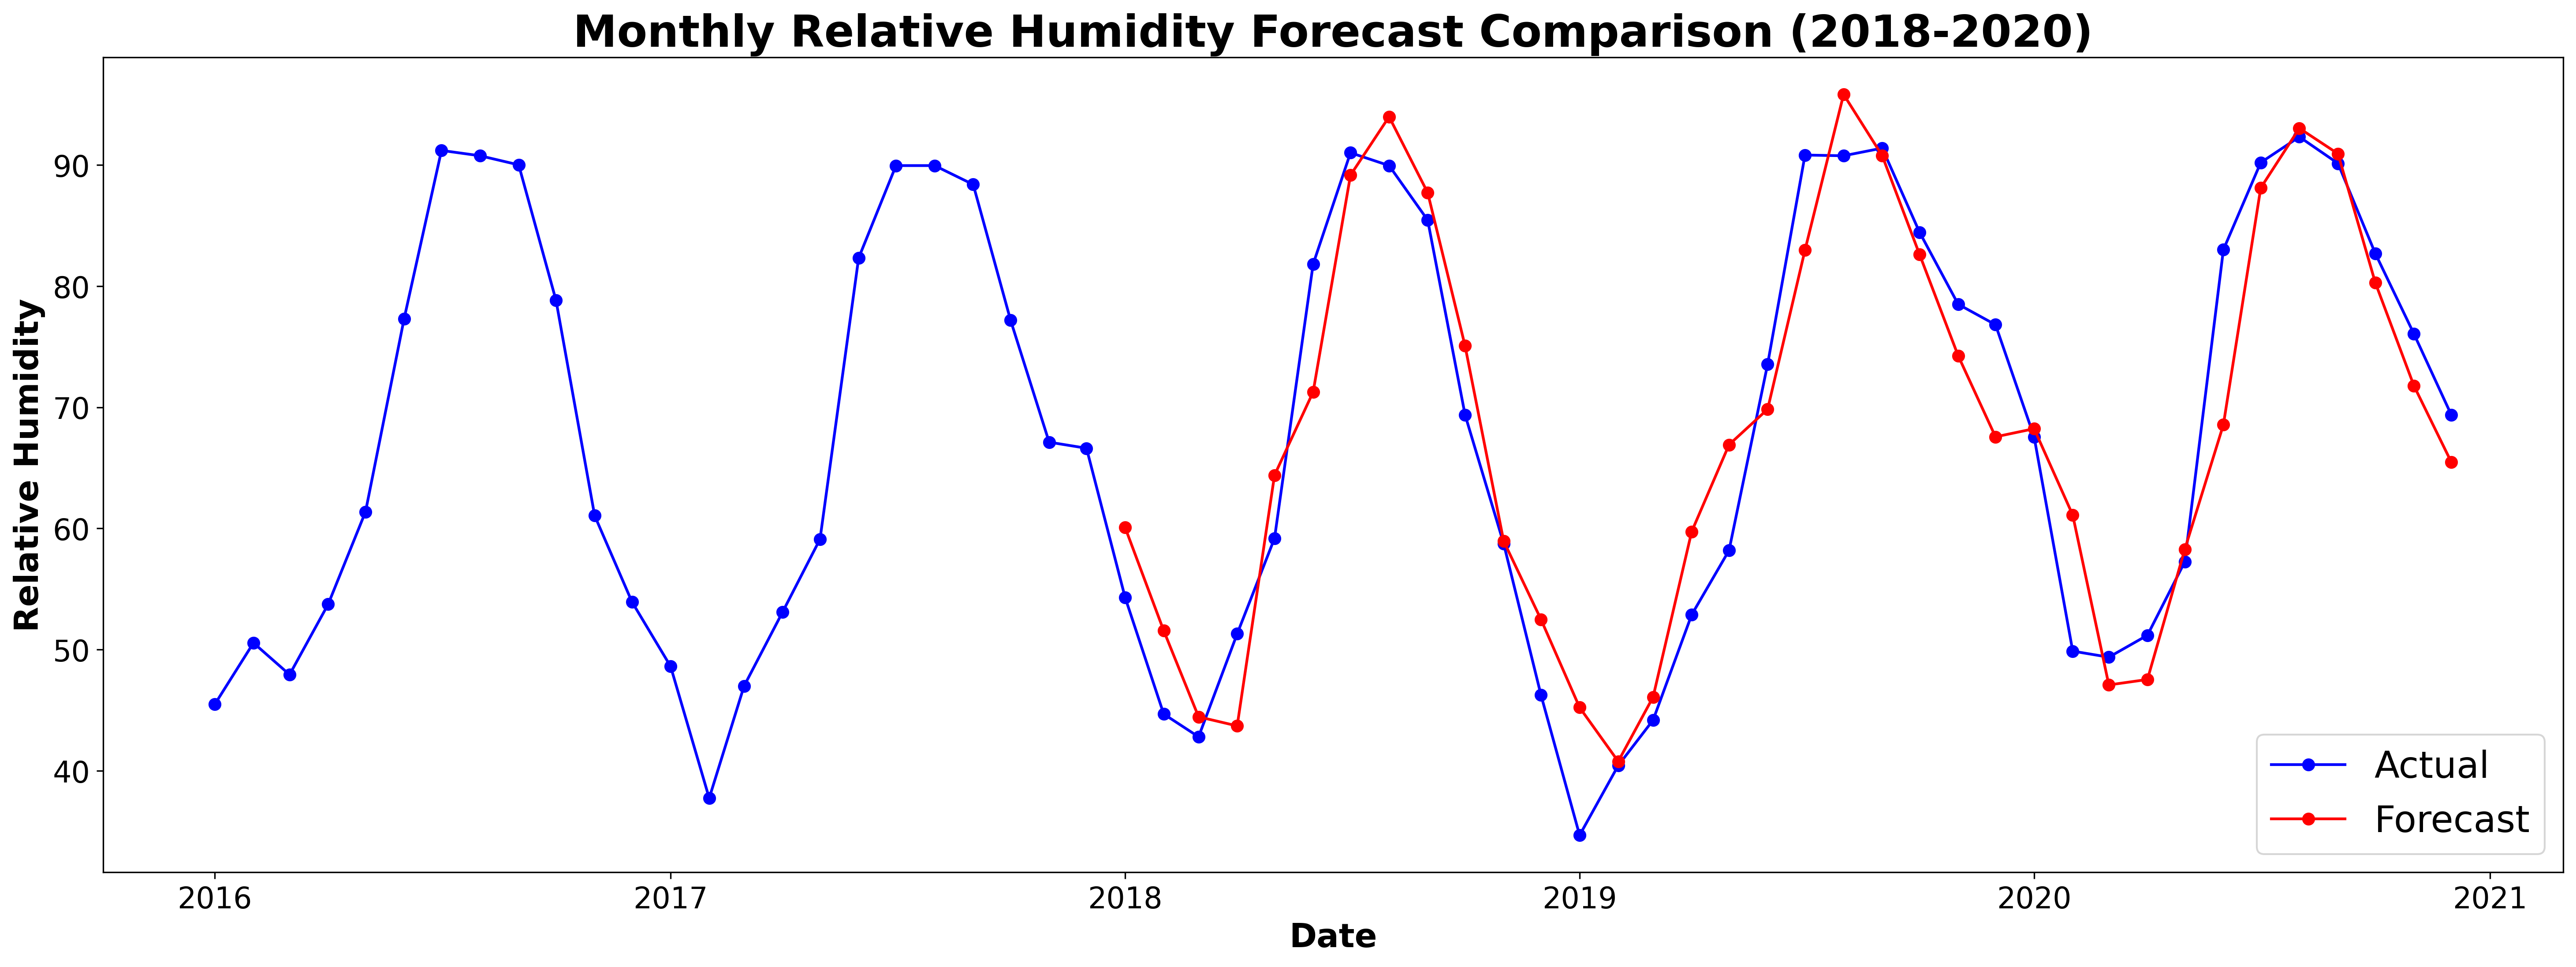

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Monthly Relative Humidity Forecast Comparison (2018-2020)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

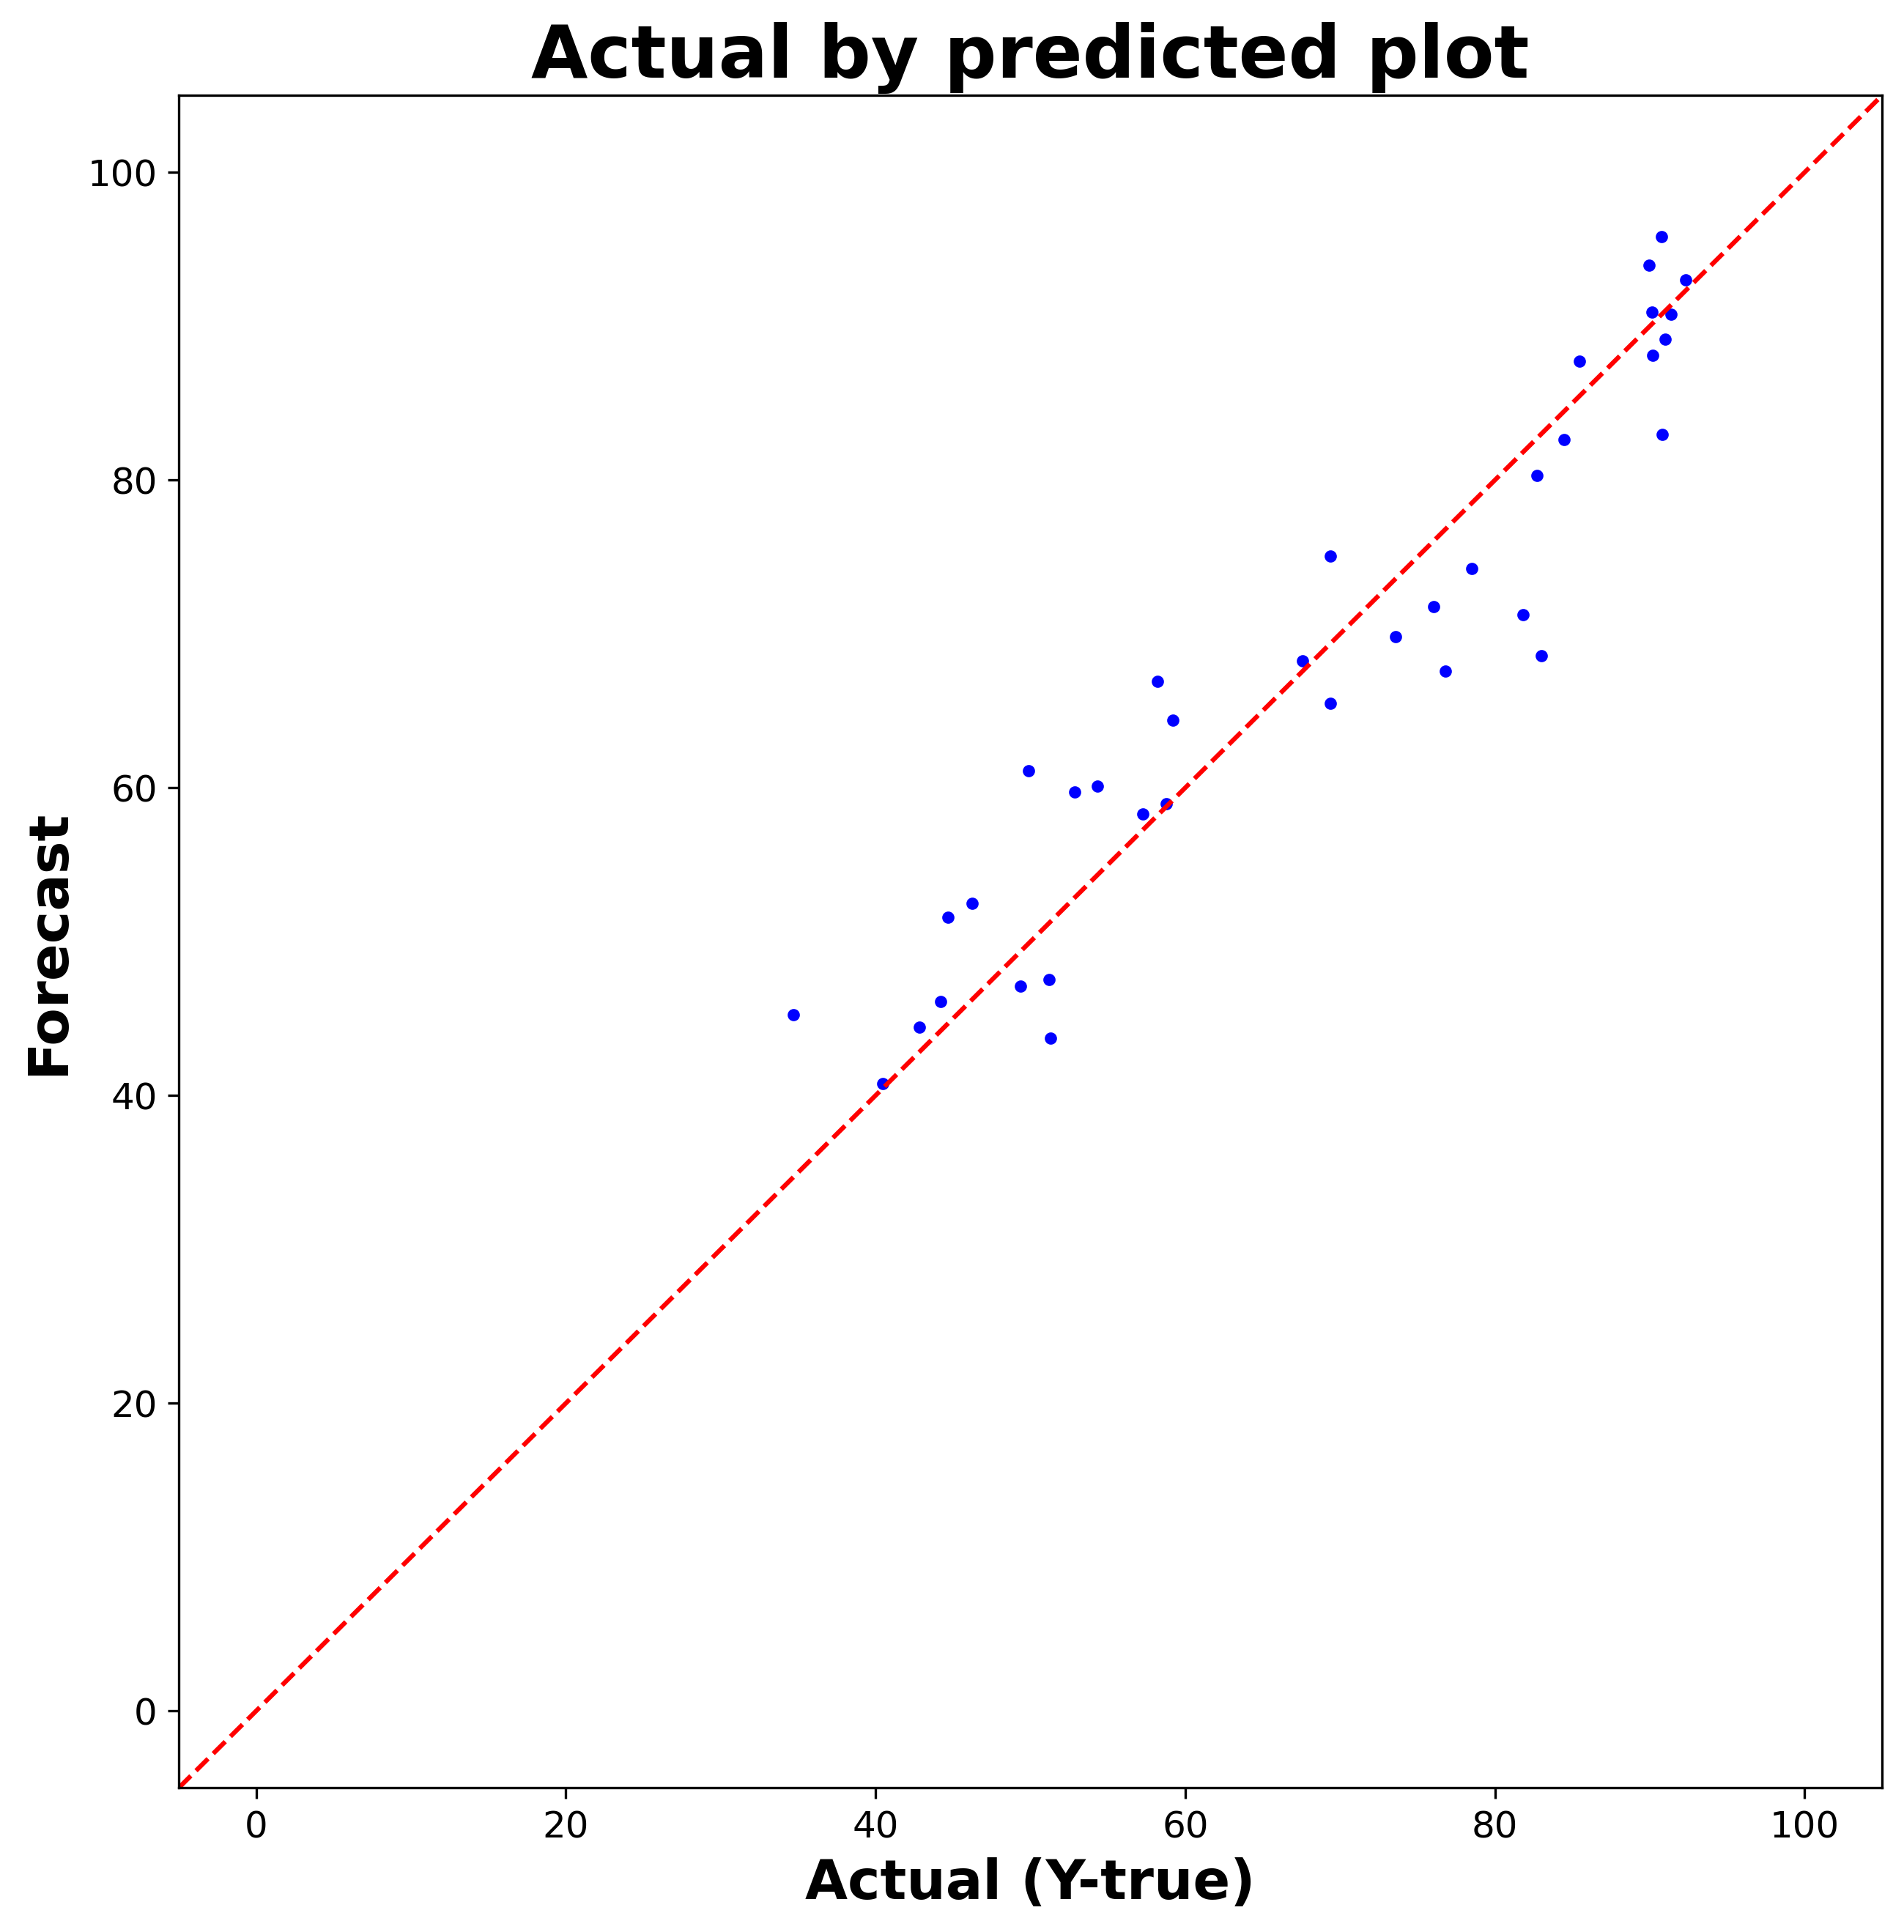

In [ ]:
# Lock the scale of axis by Y_true
max_value=100+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()